# CSC3831 Coursework Part 1: Data Engineering



In [6]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

# Loading in the corrupted dataset to be used in analysis and imputation
hc_path = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv'
houses_corrupted = pd.read_csv(hc_path, header=0)

# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]
- Perform ad hoc EDA to understand and describe what you see in the raw dataset
  - Include graphs, statistics, and written descritpions as appropriate
  - Any extra information about the data you can provide here is useful, think about performing an analysis (ED**A**), what would you find interesting or useful?
- Identify features with missing records, outlier records


In [2]:
houses_corrupted.head()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,NaN,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,NaN,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


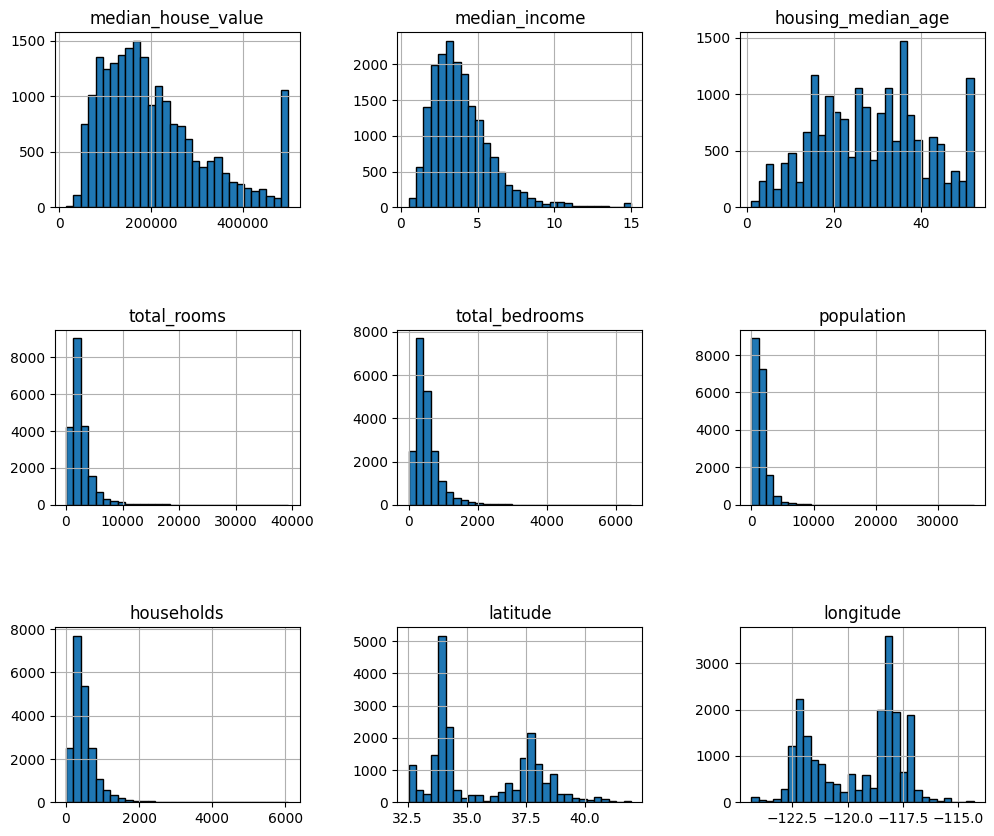

In [ ]:
import matplotlib.pyplot as plt

houses_corrupted.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [3]:
houses_corrupted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [48]:
missing_count=houses_corrupted.isnull().sum()
missing_count = missing_count[missing_count>0]

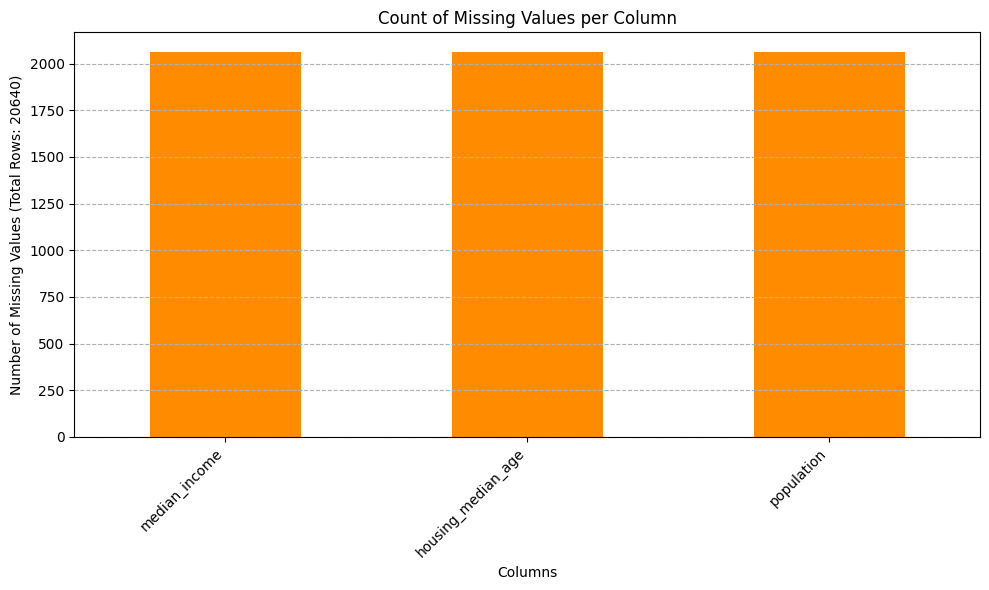

In [76]:
plt.figure(figsize=(10, 6))
missing_count.plot(kind='bar', color='darkorange')
plt.title('Count of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values (Total Rows: 20640)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

Since the number of missing values in the of all the columns is the same, it is worth checking if the same rows have 3 of these values missing all the time as it might suggest some direct patterns that can be handled in one step, based on the result below, the data seems to be missing randomly or without any direct correlation 

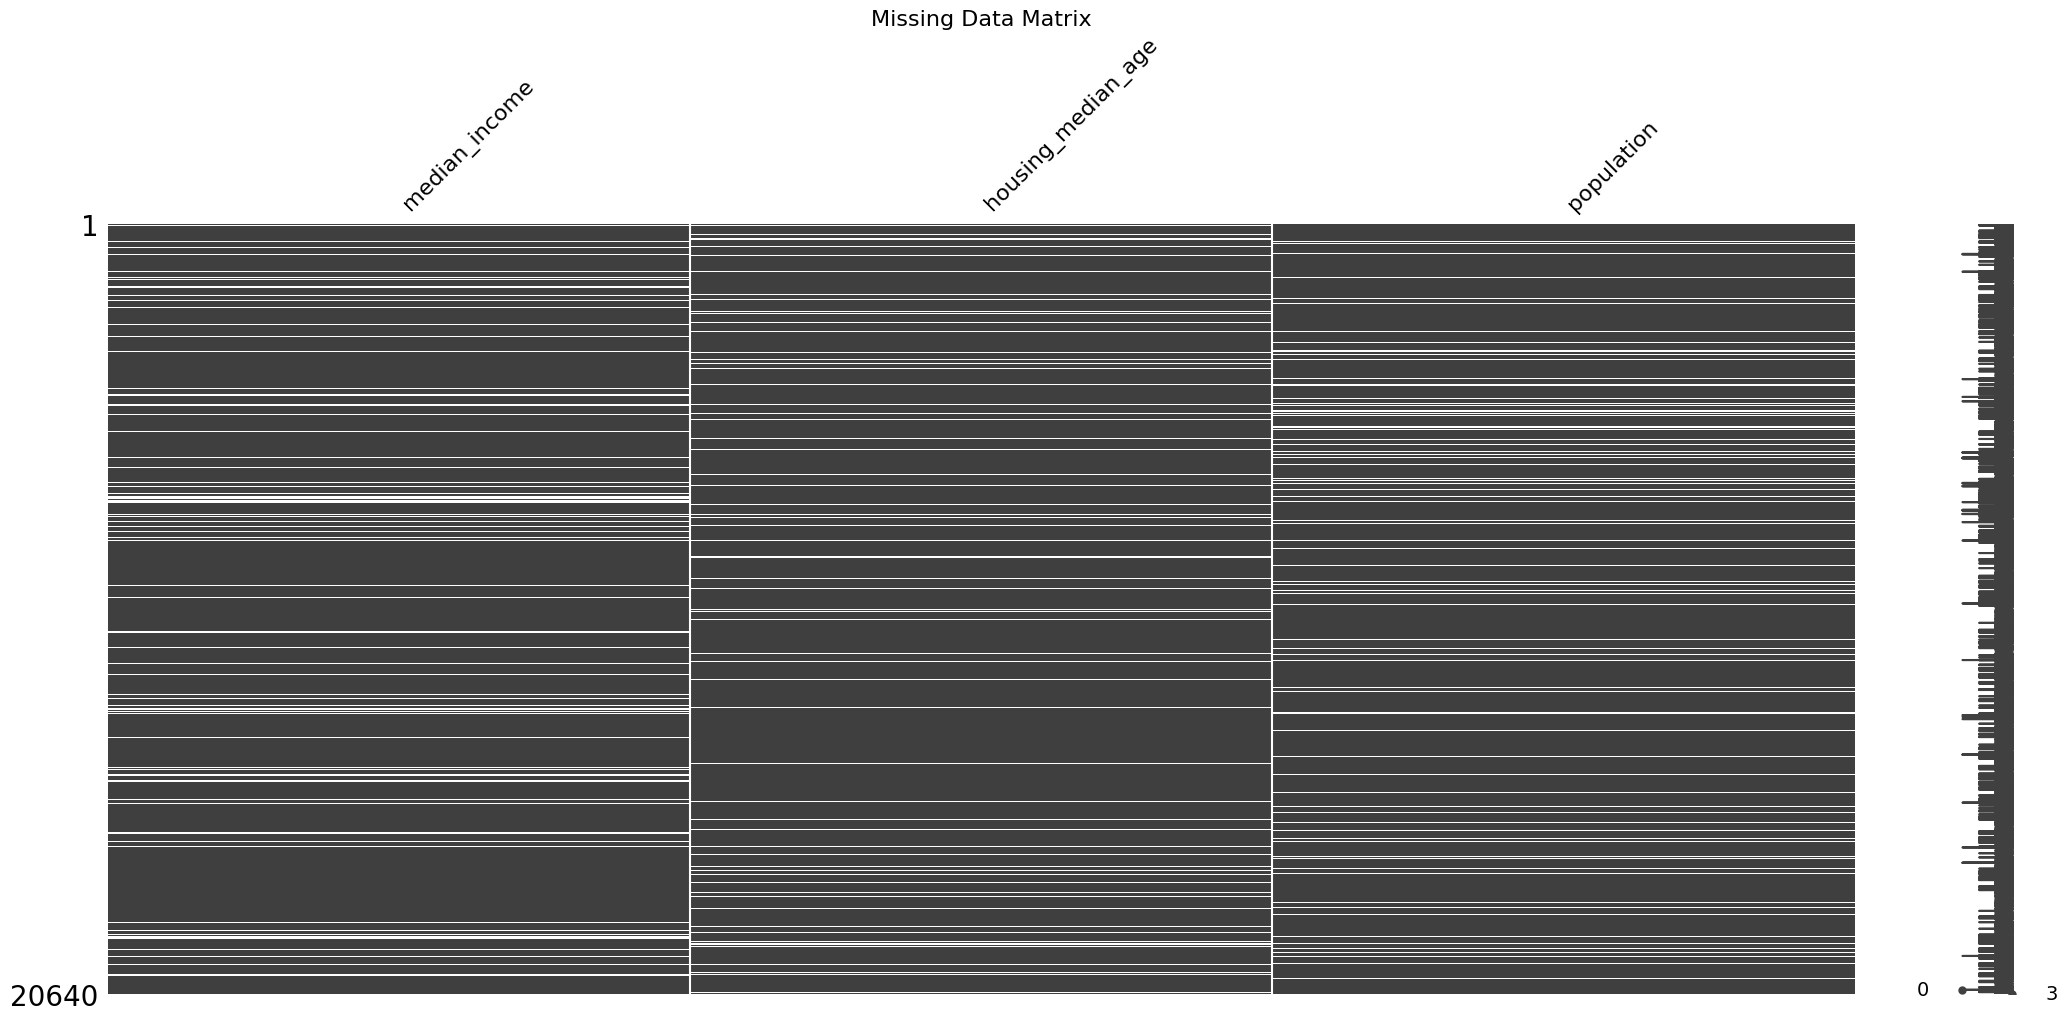

In [ ]:
# mapping the missing columns to check if there are any direct correlations in the data that is missing or any direct relationships 
msno.matrix(houses_corrupted[["median_income", "housing_median_age", "population"]])
plt.title('Missing Data Matrix', fontsize=16)
plt.show()


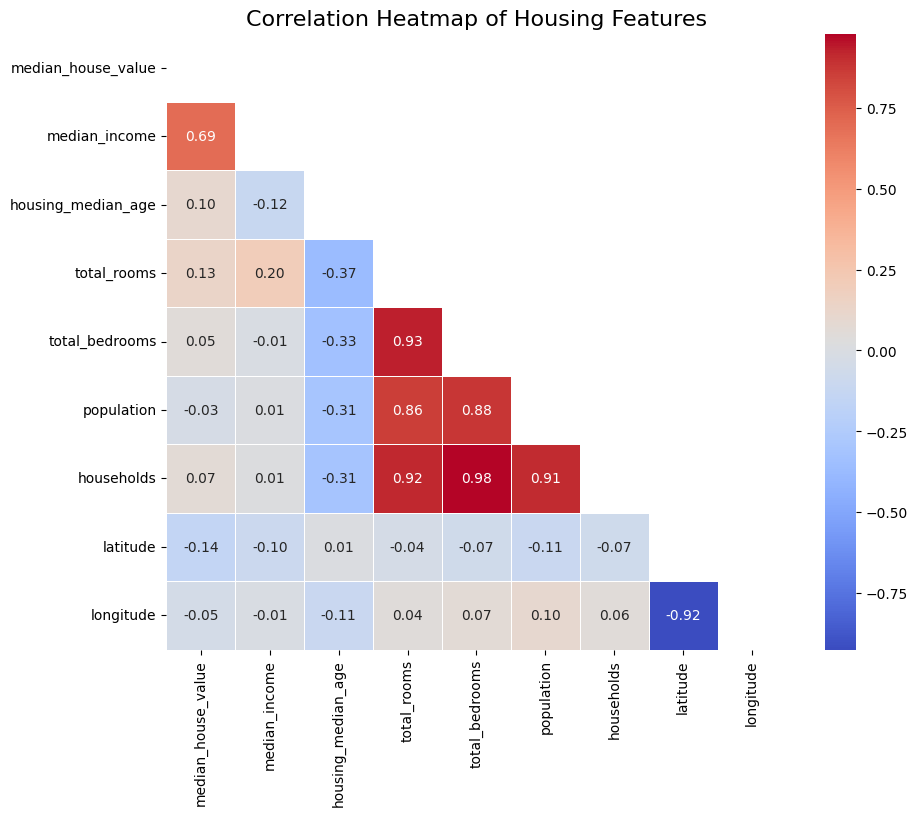

In [68]:
# Calculate the correlation matrix
correlation_matrix = houses_corrupted.corr()

plt.figure(figsize=(10, 8))
#for masking the upper half o the triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',  
    mask=mask,
    fmt=".2f",
    linewidths=0.5,
    cbar=True
)

plt.title('Correlation Heatmap of Housing Features', fontsize=16)
plt.show()

### Most Correlated Features:  
1. Households and total rooms  
2. Households and total_bedrooms  
3. Households and total_population  
4. Total Bedrooms and total rooms  
5. Population and total rooms  
6. Median income and Median house value (people who earn more tend to have more expensive houses)

Text(0, 0.5, 'Median income (x10k USD)')

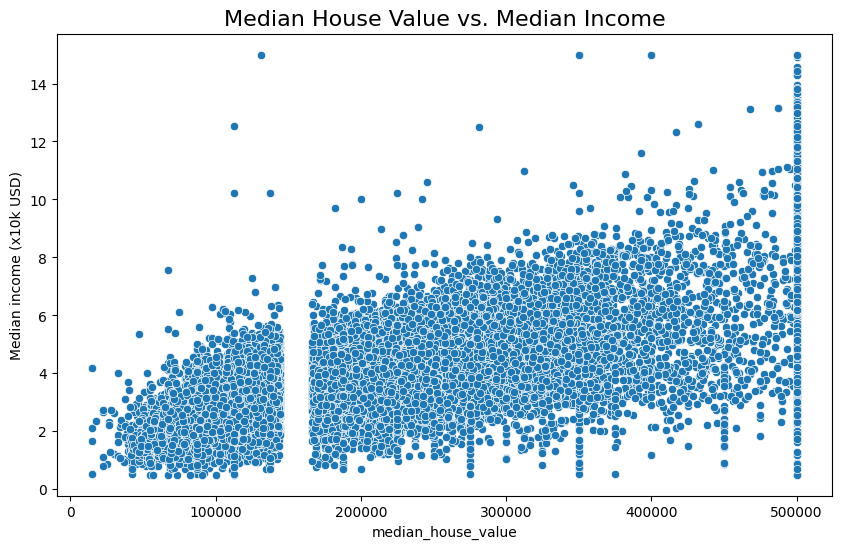

In [80]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=houses_corrupted, x='median_house_value', y='median_income')
plt.title('Median House Value vs. Median Income', fontsize=16)
plt.ylabel('Median income (x10k USD)')

### Trends or patterns identified  
1. The max median house value is capped at 500000 USD  
2. There is a "gap" on the x-axis around the 150,000 USD mark where the median income was rounded off to a lower value.  
_Hypothesis_: The council has done this to create a logical cut of point a create a classifcation for low and high value houses for each of these locations 

### 2. Outlier Identification [10]
- Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
- Utilise an algorithmic outlier detection method of your choice
- Compare results and decide what to do with identified outleirs
  - Include graphs, statistics, and written descriptions as appropriate
- Explain what you are doing, and why your analysis is appropriate
- Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


In [ ]:
houses_corrupted.describe(include='all')

### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [ ]:
# Use this dataset for comparison against the imputed datasets
h_path = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv'

### 4. Conclusions & Throughts [3]
- Discuss methods used for anomaly detection, pros/cons of each method
- Discuss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation